# Graph Neural Network approach (LightGCN)

In [25]:
import random

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch_geometric.nn.conv import MessagePassing

from torch_geometric.utils import degree

from tqdm.notebook import tqdm

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
ratings_path = '../data/raw/ml-100k/u.data'

# Load users data

users_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv(ratings_path, sep='\t',
                 names=users_columns, encoding='latin-1')

# Remove movies with less than 3 ratings
df = df[df['rating'] >= 3]

In [27]:
# Split into train and test
train, test = train_test_split(
    df.values, test_size=0.2, random_state=RANDOM_SEED)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [28]:
print("Train Size:", len(train_df))
print("Test Size:", len(test_df))

Train Size: 66016
Test Size: 16504


In [29]:
le_user = LabelEncoder()
le_item = LabelEncoder()

train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)

train_df['movie_id_idx'] = le_item.fit_transform(train_df['movie_id'].values)

train_user_ids = train_df['user_id'].unique()
train_movie_ids = train_df['movie_id'].unique()

test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) &
    (test_df['movie_id'].isin(train_movie_ids))
]

test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['movie_id_idx'] = le_item.transform(test_df['movie_id'].values)

In [30]:
n_users = train_df["user_id_idx"].nunique()
n_items = train_df["movie_id_idx"].nunique()
print("Unique users:", n_users)
print("Unique movies:", n_items)

Unique users: 943
Unique movies: 1547


In [31]:
def data_loader(data, batch_size, n_usr, n_itm):
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['movie_id_idx']\
        .apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    users = [random.choice(indices) for _ in range(
        batch_size)] if n_usr < batch_size else random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users, columns=['users'])

    interected_items_df = pd.merge(interected_items_df, users_df,
                                   how='right', left_on='user_id_idx', right_on='users')

    pos_items = interected_items_df['movie_id_idx']\
        .apply(lambda x: random.choice(x)).values
    neg_items = interected_items_df['movie_id_idx']\
        .apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

In [47]:
# create an edge index for training (ajdacency matrix)

u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.movie_id_idx) + n_users

train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),
    torch.cat([i_t, u_t])
)).to(device)

In [35]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [36]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items
    ):
        super(RecSysGNN, self).__init__()

        self.model = LightGCNConv()
        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return emb0, out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

In [37]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = (1 / 2) * (
        user_emb0.norm().pow(2) +
        pos_emb0.norm().pow(2) +
        neg_emb0.norm().pow(2)
    ) / float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [38]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(
        user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_df['user_id_idx'].values),
        torch.LongTensor(train_df['movie_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse_coo_tensor(
        i, v, (n_users, n_items), device=device).to_dense()

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu(
    ).numpy(), columns=['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[[
        'top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[[
        'user_ID', 'top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item
    # interactions
    test_interacted_items = test_data.groupby(
        'user_id_idx')['movie_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df,
                          how='left', left_on='user_id_idx', right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(
        metrics_df.movie_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x: len(
        x['intrsctn_itm'])/len(x['movie_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(
        lambda x: len(x['intrsctn_itm'])/K, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [39]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 10

In [40]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []

    for _ in tqdm(range(EPOCHS)):
        n_batch = int(len(train)/BATCH_SIZE)

        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []

        model.train()
        for _ in range(n_batch):

            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(
                train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(
                users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
                users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(
                out, (n_users, n_items))
            test_topK_recall,  test_topK_precision = get_metrics(
                final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
            )

        loss_list_epoch.append(round(np.mean(final_loss_list), 4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))

    return (
        loss_list_epoch,
        bpr_loss_list_epoch,
        reg_loss_list_epoch,
        recall_list,
        precision_list
    )

### Train and eval LightGCN

In [41]:
model = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [42]:
loss, bpr_loss, reg_loss, recall, precision = \
    train_and_eval(model, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [43]:
epoches = [(i + 1) for i in range(EPOCHS)]

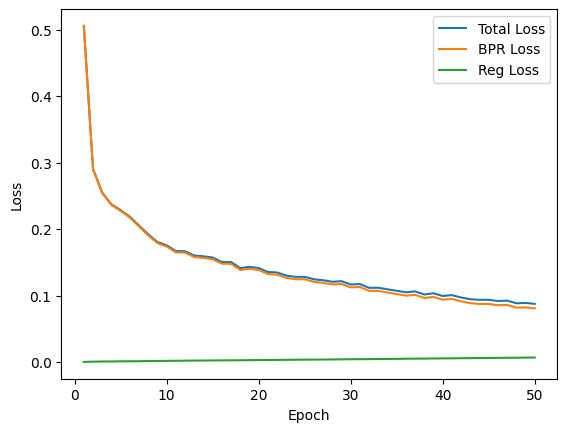

In [44]:
plt.plot(epoches, loss, label="Total Loss")
plt.plot(epoches, bpr_loss, label="BPR Loss")
plt.plot(epoches, reg_loss, label="Reg Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

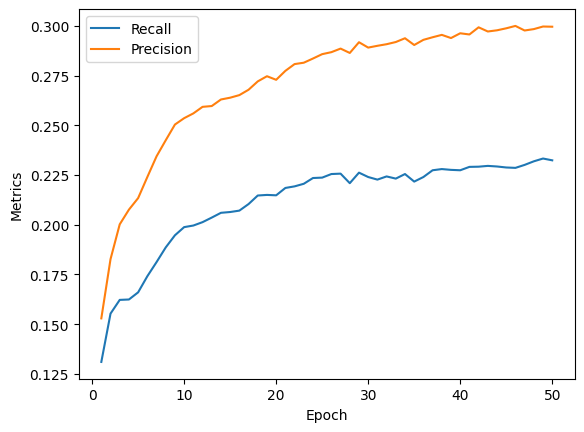

In [45]:
plt.plot(epoches, recall, label="Recall")
plt.plot(epoches, precision, label="Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()

In [49]:
print(f"Precision@10: {precision[-1]}")
print(f"Recall@10: {recall[-1]}")

Precision@10: 0.2996
Recall@10: 0.2324


In [50]:
# save model
torch.save(model.state_dict(), '../models/light-gcn.pt')

In [52]:
# load model
model = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items
)

model.load_state_dict(torch.load('../models/light-gcn.pt'))

model.to(device)

model.eval()

with torch.no_grad():
    _, out = model(train_edge_index)
    final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
    test_topK_recall,  test_topK_precision = get_metrics(
        final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
    )

print(f"Precision@10: {test_topK_precision}")
print(f"Recall@10: {test_topK_recall}")

Precision@10: 0.2995731056563501
Recall@10: 0.232374479145842
